In [190]:
%matplotlib notebook
import pandas as pd

In [2]:
df = pd.read_csv('data/zika/cdc_zika.csv', sep=',')

/home/cloud-user/code/source_finding/venv/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [37]:
df = df[df.location.map(lambda s: isinstance(s, str))]

In [55]:
target_fields = pd.read_csv('data/zika/target_data_fields.txt')
target_fields = set(target_fields.as_matrix().flatten())

In [68]:
active_rows = df[df['data_field'].map(
    lambda s: s in target_fields)]
print('n. reported cases {}'.format(len(active_rows)))

n. reported cases 5221


In [70]:
unique_places = active_rows.location.unique()
print('n. unique places {}'.format(len(unique_places)))

n. unique places 416


In [122]:
country_locations = {p for p in unique_places if len(p.split('-')) == 1}
countries = {p.split('-')[0] for p in unique_places if len(p.split('-')) > 1}
locations_to_remove = country_locations.intersection(countries)
active_rows = active_rows[active_rows.location.map(lambda l: l not in locations_to_remove)]
print('after removing country locations, n. reported cases {}'.format(len(active_rows)))

after removing country locations, n. reported cases 4845


In [90]:
names = ['Airport ID', 'Name', 'City', 'Country', 'IATA', 'ICAO', 'Latitude', 'Longitude', 'Altitude', 'Timezone', 'DST', 'Tz', 'Type', 'Source']
airports = pd.read_csv('data/zika/airports.dat', sep=',', names=names)
airports.head(10)

,Airport ID,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Tz,Type,Source
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,U,Pacific/Port_Moresby,airport,OurAirports
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10,U,Pacific/Port_Moresby,airport,OurAirports
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby,airport,OurAirports
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10,U,Pacific/Port_Moresby,airport,OurAirports
5,6,Wewak International Airport,Wewak,Papua New Guinea,WWK,AYWK,-3.583830,143.669006,19,10,U,Pacific/Port_Moresby,airport,OurAirports
6,7,Narsarsuaq Airport,Narssarssuaq,Greenland,UAK,BGBW,61.160500,-45.425999,112,-3,E,America/Godthab,airport,OurAirports
7,8,Godthaab / Nuuk Airport,Godthaab,Greenland,GOH,BGGH,64.190903,-51.678101,283,-3,E,America/Godthab,airport,OurAirports
8,9,Kangerlussuaq Airport,Sondrestrom,Greenland,SFJ,BGSF,67.012222,-50.711603,165,-3,E,America/Godthab,airport,OurAirports
9,10,Thule Air Base,Thule,Greenland,THU,BGTL,76.531197,-68.703201,251,-4,E,America/Thule,airport,OurAirports


In [111]:
def map_location_to_airports(location, airports):
    segs = location.split('-')
    def replace_underscore(s):
        return s.replace('_', ' ')
    if len(segs) > 1:        
        val = replace_underscore(segs[1])
        field = 'City'
    else:
        val = replace_underscore(segs[0])
        field = 'Country'
    result = airports[airports[field] == val]    
    airports = set(result['IATA'].as_matrix())    
    return set(filter(lambda s: s != '\\N', airports))                

In [126]:
unique_locations = active_rows.location.unique()
loc2airport = {}
for loc in unique_locations:
    airport = map_location_to_airports(loc, airports)
    loc2airport[loc] = airport

In [127]:
locations_with_airports = set(filter(lambda l: loc2airport[l], loc2airport))
print('n. unique locations {}'.format(len(unique_locations)))
print('n. unique locations with airports {}'.format(len(locations_with_airports)))

n. unique locations 409
n. unique locations with airports 62


In [129]:
active_rows = active_rows[active_rows.location.map(lambda l: l in locations_with_airports)]
print('after filtering out locations without airports, n. active rows {}'.format(len(active_rows)))

after filtering out locations without airports, n. active rows 895


In [131]:
# now construct location network
names = ['Airline', 'Airline ID',
         'src','src_id', 'des', 'des_id', 
         'Codeshare', 'Stops', 'Equipment']
routes = pd.read_csv('data/zika/routes.dat', sep=',', names=names)

In [136]:
useful_airports = {a for l in locations_with_airports
                   for a in loc2airport[l]}
print(useful_airports)

{'PBC', 'GRU', 'MGA', 'CTC', 'ZCL', 'DGO', 'CNQ', 'RSA', 'LUQ', 'EZE', 'SJU', 'NQN', 'GPS', 'RZA', 'SCL', 'LGA', 'ETR', 'CGH', 'AZS', 'STI', 'CPE', 'FMA', 'IRJ', 'SIG', 'TUC', 'STD', 'JAL', 'SLA', 'POP', 'MDE', 'LEN', 'LRM', 'IDL', 'CLQ', 'EPS', 'SOA', 'SCQ', 'OAX', 'STS', 'HYI', 'CEM', 'MDZ', 'OCW', 'SDQ', 'IAD', 'TXA', 'ODB', 'JFK', 'BRX', 'AGU', 'HEX', 'CUU', 'VVI', 'SRZ', 'GRX', 'DRO', 'SAF', 'JUJ', 'ESM', 'PRA', 'DCA', 'COR', 'SFN', 'AEP', 'SRA', 'ARA', 'SLP'}


In [137]:
print('n. routes {}'.format(len(routes)))

n. routes 67663


In [150]:
routes.head(10)

,Airline,Airline ID,src,src_id,des,des_id,Codeshare,Stops,Equipment
220,2Z,1729,CAC,2535,GRU,2564,NaN,0,AT7
225,2Z,1729,DOU,7380,GRU,2564,NaN,0,AT7
227,2Z,1729,GRU,2564,CAC,2535,NaN,0,AT7
228,2Z,1729,GRU,2564,DOU,7380,NaN,0,AT7
229,2Z,1729,GRU,2564,RAO,2613,NaN,0,AT7
230,2Z,1729,GRU,2564,UBA,2635,NaN,0,AT7
231,2Z,1729,GRU,2564,UDI,2633,NaN,0,AT7
232,2Z,1729,GRU,2564,VDC,6039,NaN,0,AT7
244,2Z,1729,RAO,2613,GRU,2564,NaN,0,AT7
252,2Z,1729,UBA,2635,GRU,2564,NaN,0,AT7


In [138]:
routes = routes[routes.src.map(lambda s: s in useful_airports) | routes.des.map(lambda s: s in useful_airports)]
print('filtering out irrelevant routes, n.routes {}'.format(len(routes)))

filtering out irrelevant routes 3610


In [160]:
airports.head(2)

,Airport ID,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Tz,Type,Source
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.08169,145.391998,5282,10,U,Pacific/Port_Moresby,airport,OurAirports
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.20708,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports


In [169]:
air2loc = {}
loc2coord = {}
for l in locations_with_airports:
    for a in loc2airport[l]:
        air2loc[a] = l
        air = airports[airports['IATA'] == a].iloc[0]
        loc2coord[l] = (air['Longitude'], air['Latitude'])

In [210]:
from graph_tool import Graph
g = Graph(directed=True)
locations_with_airports = list(sorted(locations_with_airports))

loc2node = {}
for i, l in enumerate(locations_with_airports):
    g.add_vertex()
    loc2node[l] = i
loc = g.new_vertex_property('string')
loc.set_2d_array(np.array(locations_with_airports))

In [211]:
lonlat = g.new_vertex_property('vector<float>')
for i, l in enumerate(locations_with_airports):
    lonlat[i] = loc2coord[l] 

In [212]:
g.vertex_properties['name'] = loc
g.vertex_properties['lonlat'] = lonlat

In [213]:
edges = set()
for i, r in routes.iterrows():
    sa, da = r['src'], r['des']
    if sa in air2loc and da in air2loc:  # location
        s, d = air2loc[sa], air2loc[da]
        edges.add((loc2node[s], loc2node[d]))  # might have duplicate
        
for u, v in edges:
    g.add_edge(u, v)

In [214]:
g.save('data/zika/graph.gt')

In [217]:
print(g.num_vertices())
print(g.num_edges())

62
89


In [218]:
import cartopy
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


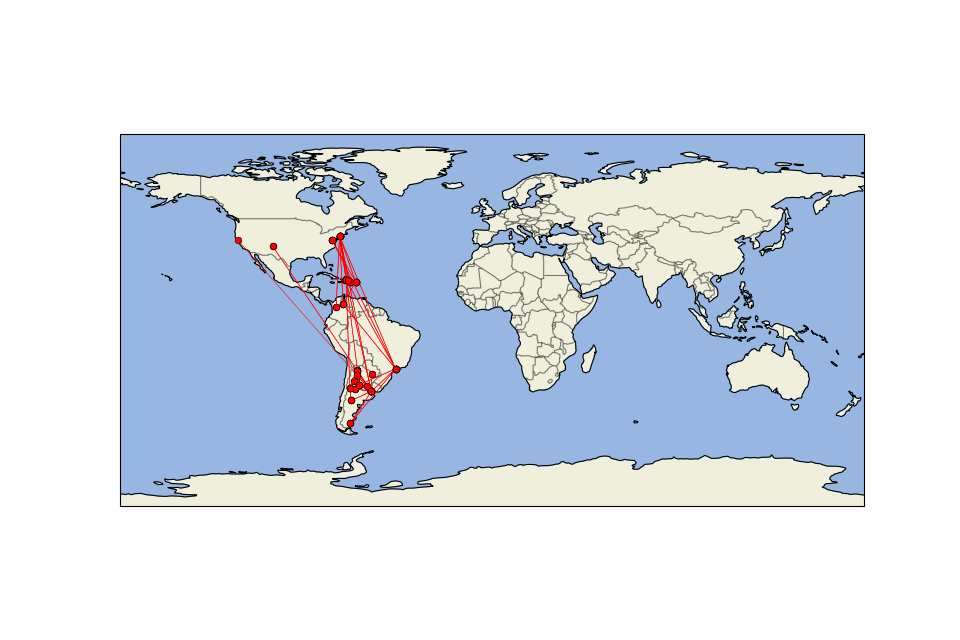

In [220]:
freq = None
fig = plt.figure(figsize=(12, 8))
# create new figure, axes instances.
lonlat = g.vertex_properties['lonlat']
lat = []
lon = []
for u, v in g.edges():
    try:
        lon.append([lonlat[u][0], lonlat[v][0]])
        lat.append([lonlat[u][1], lonlat[v][1]])
    except IndexError:
        print(u, v)

if not freq:
    freq = [0.5]*g.num_edges()

# setup map projection.
ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=.5)

for la, lo, fq in zip(lat, lon, freq):
    plt.plot(lo, la, color='red', linewidth=fq, marker='o', transform=ccrs.PlateCarree())

ax.set_title('')
# plt.savefig('figs/' + str(fname) + '.png')
